# 1° PROYECTO INDIVIDUAL Nº1 - Machine Learning Operations (MLOps) 
## by Juan Camilo Candela COL

In [60]:
# Importación de bibliotecas necesarias
import pandas as pd
import numpy as np
import re
import json
import ast
from pandas import json_normalize
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


## Transformaciones Necesarias - MVP

In [61]:
# Dataset Inicial
df_anidado = pd.read_csv("movies_dataset.csv")

# Desanidar columnas / propuestas
df_desanidado_collection = json_normalize(df_anidado['belongs_to_collection'])
df_desanidado_spoken = json_normalize(df_anidado['spoken_languages'])
df_desanidado_production = json_normalize(df_anidado['production_countries'])

# Concatenar nuevamente
df_desanidado = pd.concat([df_anidado.drop(columns=['belongs_to_collection','spoken_languages','production_countries']), df_desanidado_collection, df_desanidado_spoken, df_desanidado_production], axis=1)

# Los valores nulos de los campos revenue, budget deben ser rellenados por el número '0'
df_desanidado['revenue'].fillna(0, inplace=True)
df_desanidado['budget'].fillna(0, inplace=True)

# Los valores nulos del campo release date deben eliminarse.
df_desanidado.dropna(subset=['release_date'], inplace=True)

# formato AAAA-mm-dd, además deberán crear la columna release_year donde extraerán el año de la fecha de estreno.
df_desanidado['release_date'] = pd.to_datetime(df_desanidado['release_date'], format='%Y-%m-%d', errors='coerce')
df_desanidado['release_year'] = df_desanidado['release_date'].dt.year


# Función previa - Transformación #5
def calcular_retorno_inversion(revenue, budget):
    if pd.notna(revenue) and pd.notna(budget):
        try:
            revenue = float(revenue)
            budget = float(budget)
            if budget != 0:
                return revenue / budget
            else:
                return 0
        except ValueError:
            return 0
    else:
        return 0

# Crear la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo 
# estas dos últimas revenue / budget, cuando no hay datos disponibles para calcularlo, deberá tomar el valor 0.
df_desanidado['return'] = df_desanidado.apply(lambda row: calcular_retorno_inversion(row['revenue'], row['budget']), axis=1)

# Eliminar las columnas que no serán utilizadas: video,imdb_id,adult,original_title,poster_path y homepage.
df_desanidado = df_desanidado.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage'], errors='ignore')


# imprimir filas iniciales
df_desanidado.head()


C:\Users\jccan\AppData\Local\Temp\ipykernel_30564\3231080579.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anidado = pd.read_csv("movies_dataset.csv")


,budget,genres,id,original_language,overview,popularity,production_companies,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,release_year,return
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,373554033.0,81.0,Released,NaN,Toy Story,7.7,5415.0,1995.0,12.451801
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995.0,4.043035
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995.0,0.000000
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995.0,5.090760
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995.0,0.000000


In [62]:
# Insumo Credits
df_credits = pd.read_csv("credits.csv", low_memory=False)

# Tipo de dato ID y Combinación con DataFrame objetivo
df_desanidado['id'] = df_desanidado['id'].astype(int)
df_combinado = df_desanidado.merge(df_credits, on='id', how='left') 

# Eliminar los valores duplicados en la columna 'title'
df_combinado.drop_duplicates(subset=['title'], inplace=True)
# Mostrar el DataFrame combinado
df_combinado.head()

ValueError: invalid literal for int() with base 10: '1997-08-20'

## Exploratory Data Analysis-EDA

In [42]:
# desplegar información df_desanidado
print(df_desanidado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 45379 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                45379 non-null  object        
 1   genres                45379 non-null  object        
 2   id                    45379 non-null  object        
 3   original_language     45368 non-null  object        
 4   overview              44438 non-null  object        
 5   popularity            45377 non-null  object        
 6   production_companies  45379 non-null  object        
 7   release_date          45376 non-null  datetime64[ns]
 8   revenue               45379 non-null  float64       
 9   runtime               45130 non-null  float64       
 10  status                45296 non-null  object        
 11  tagline               20398 non-null  object        
 12  title                 45376 non-null  object        
 13  vote_average         

In [43]:
# Mantener solo los valores únicos en la columna 'title'
df_desanidado.drop_duplicates(subset=['title'], keep='first', inplace=True)

# Eliminar filas que contienen valores nulos en las columnas 'homepage', 'imdb_id', 'popularity' y 'overview'
df_desanidado.dropna(subset=['original_language', 'runtime'], inplace=True)

# Rellenar valores nulos en las columnas 'belongs_to_collection', 'overview', 'poster_path', 'tagline' y 'status' con una cadena vacía
columnas_a_rellenar = ['original_language', 'overview', 'status', 'tagline']
df_desanidado[columnas_a_rellenar] = df_desanidado[columnas_a_rellenar].fillna('')

# Contar el número de valores nulos en cada columna y mostrarlo
print("Recuento de valores nulos por columna:")
print(df_desanidado.isnull().sum())


Recuento de valores nulos por columna:
budget                  0
genres                  0
id                      0
original_language       0
overview                0
popularity              0
production_companies    0
release_date            0
revenue                 0
runtime                 0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
release_year            0
return                  0
dtype: int64


In [44]:
print(df_desanidado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41946 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                41946 non-null  object        
 1   genres                41946 non-null  object        
 2   id                    41946 non-null  object        
 3   original_language     41946 non-null  object        
 4   overview              41946 non-null  object        
 5   popularity            41946 non-null  object        
 6   production_companies  41946 non-null  object        
 7   release_date          41946 non-null  datetime64[ns]
 8   revenue               41946 non-null  float64       
 9   runtime               41946 non-null  float64       
 10  status                41946 non-null  object        
 11  tagline               41946 non-null  object        
 12  title                 41946 non-null  object        
 13  vote_average         

In [45]:
# Convertir las columnas 'budget' y 'popularity' a tipo numérico (float64)
df_desanidado['budget'] = pd.to_numeric(df_desanidado['budget'], errors='coerce')
df_desanidado['popularity'] = pd.to_numeric(df_desanidado['popularity'], errors='coerce')

# Rellenar valores nulos en la columna 'runtime' con el promedio de los valores no nulos
df_desanidado['runtime'].fillna(df_desanidado['runtime'].mean(), inplace=True)

# Cambiar el tipo de dato del campo 'budget' a float64
df_desanidado['budget'] = df_desanidado['budget'].astype(float)

# Verificar los tipos de datos después de las conversiones
print("Tipos de datos después de la conversión:")
print(df_desanidado.dtypes)


Tipos de datos después de la conversión:
budget                         float64
genres                          object
id                              object
original_language               object
overview                        object
popularity                     float64
production_companies            object
release_date            datetime64[ns]
revenue                        float64
runtime                        float64
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                     float64
release_year                   float64
return                         float64
dtype: object


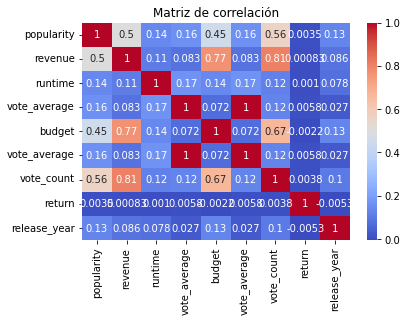

In [46]:
# Seleccionar solo las columnas de interés
columnas_seleccionadas = ['popularity', 'revenue', 'runtime', 'vote_average', 'budget', 'vote_average', 'vote_count', 'return', 'release_year']
df_seleccionado = df_desanidado[columnas_seleccionadas]

# Calcular la matriz de correlación para las columnas seleccionadas
correlation_matrix = df_seleccionado.corr()

# Visualizar la matriz de correlación utilizando un mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un mapa de calor con anotaciones y una paleta de colores frescos y cálidos
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Establecer el título del mapa de calor
plt.title('Matriz de correlación')

# Mostrar el mapa de calor
plt.show()



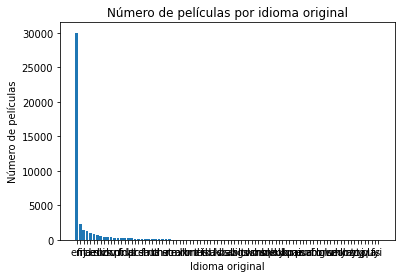

In [47]:
# Explorar la distribución de valores únicos en 'original_language'
plt.bar(df_desanidado['original_language'].value_counts().index, df_desanidado['original_language'].value_counts())
plt.xlabel('Idioma original')
plt.ylabel('Número de películas')
plt.title('Número de películas por idioma original')
plt.show()

In [48]:
# Mostrar las 10 principales categorías de 'genres'
top_genres = df_desanidado['genres'].value_counts().nlargest(10)
print(top_genres)

genres
[{'id': 18, 'name': 'Drama'}]                                                                    4531
[{'id': 35, 'name': 'Comedy'}]                                                                   3404
[{'id': 99, 'name': 'Documentary'}]                                                              2604
[]                                                                                               2156
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                  1189
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                      1081
[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]                                  886
[{'id': 27, 'name': 'Horror'}]                                                                    877
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]     559
[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]                

In [49]:

# Función para convertir los valores de 'genres' en listas de diccionarios
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Aplicar la función para convertir los valores de 'genres'
df_desanidado['genres'] = df_desanidado['genres'].apply(convert_to_list)

# Función para obtener los nombres de género a partir de una lista de diccionarios
def get_genre_names(genre_list):
    genre_names = [genre['name'] for genre in genre_list]
    return ', '.join(genre_names)

# Aplicar la función para obtener los nombres de género como una cadena
df_desanidado['genres_str'] = df_desanidado['genres'].apply(get_genre_names)

# Mostrar el DataFrame con la nueva columna 'genres_str'
print("DataFrame con la nueva columna 'genres_str':")
print(df_desanidado[['genres', 'genres_str']].head())


DataFrame con la nueva columna 'genres_str':
                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                   genres_str  
0   Animation, Comedy, Family  
1  Adventure, Fantasy, Family  
2             Romance, Comedy  
3      Comedy, Drama, Romance  
4                      Comedy  


In [50]:
# Mostrar en forma de diccionario
top_genres = df_desanidado['genres_str'].value_counts().nlargest(10)
print(top_genres)

genres_str
Drama                     4531
Comedy                    3404
Documentary               2604
                          2156
Drama, Romance            1189
Comedy, Drama             1081
Comedy, Romance            886
Horror                     877
Comedy, Drama, Romance     559
Drama, Comedy              499
Name: count, dtype: int64


In [51]:
# Ver tabla con ajustes
df_desanidado.head()


,budget,genres,id,original_language,overview,popularity,production_companies,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,release_year,return,genres_str
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,373554033.0,81.0,Released,,Toy Story,7.7,5415.0,1995.0,12.451801,"Animation, Comedy, Family"
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995.0,4.043035,"Adventure, Fantasy, Family"
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995.0,0.000000,"Romance, Comedy"
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995.0,5.090760,"Comedy, Drama, Romance"
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995.0,0.000000,Comedy


## Sistema de Recomendación

In [56]:
# Crear una lista con los nombres de las columnas que deseas seleccionar
columnas_seleccionadas = ['title', 'genres_str', 'overview']

# Usar el método 'loc' para seleccionar solo las columnas deseadas
df_model = df_desanidado.loc[:, columnas_seleccionadas]

# Filtrar el DataFrame a uno más pequeño, en este caso solo películas de Documentary. (Overflow error)
df_documentary = df_model[df_desanidado['genres_str'].str.contains('Documentary')]
print(df_documentary.info())
print(df_documentary.head())

# Generar dataframe insumo de archivo .py (fastapi)
df_documentary.to_csv('df_insumo_fastapi.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 76 to 45452
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3769 non-null   object
 1   genres_str  3769 non-null   object
 2   overview    3769 non-null   object
dtypes: object(3)
memory usage: 117.8+ KB
None
                             title                   genres_str  \
76                       Nico Icon                  Documentary   
97   Heidi Fleiss: Hollywood Madam                  Documentary   
106                        Catwalk                  Documentary   
114          Anne Frank Remembered  Documentary, Drama, Foreign   
132                  Sonic Outlaws           Music, Documentary   

                                              overview  
76   A look into the many lives of Christa Päffgen,...  
97   A documentary crew from the BBC arrives in L.A...  
106  A documentary following Christy Turlington and...  
114  Using previous

In [55]:
# Combinar la información de 'title' y 'genres' en una nueva columna 'content'
df_modelo = df_documentary.assign(content=df_documentary['title'] + ' ' + df_documentary['genres_str'] + ' ' + df_documentary['overview'])

# Crear la matriz TF-IDF para el contenido
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo['content'])

# Calcular la similitud coseno entre las películas
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Función para obtener las películas similares basadas en un título dado
def get_similar_movies(title, cosine_sim=cosine_sim):
    idx = df_modelo[df_modelo['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Obtener las 5 películas más similares
    movie_indices = [score[0] for score in sim_scores]
    return df_modelo['title'].iloc[movie_indices]

# Probemos el sistema
lista_recomendada = get_similar_movies('Nico Icon')
print(lista_recomendada)


20822                            American Winter
37129                         Pretpark Nederland
44524    Dumb: The Story of Big Brother Magazine
39414           The Beach Boys: An American Band
12455                                 Chicago 10
Name: title, dtype: object
